<a href="https://colab.research.google.com/github/SrishtiSingh25/IISC-AI-Project/blob/main/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Download and preprocess dSprites dataset


In [15]:
# Mount Google Drive to Colab
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
# Load data from local file in Drive

data_file = '/content/drive/My Drive/path/to/dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz'

In [18]:
data = np.load (data_file, allow_pickle=True, encoding='bytes')
keys = data.keys()
if 'imgs' in keys:
    imgs = data['imgs']
    imgs = np.reshape(imgs, (imgs.shape[0], 64, 64, 1))
    imgs = imgs.astype('float32') / 255.0
else:
    print('Error: "imgs" not found in npz file')


FileNotFoundError: ignored

#Next, we define the architecture of our VAE model:

In [6]:
class VAE(tf.keras.Model):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(64, 64, 1)),
            tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(latent_dim + latent_dim)
        ])
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(units=16 * 16 * 32, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(16, 16, 32)),
            tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=(2, 2), padding="SAME", activation='relu'),
            tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=(2, 2), padding="SAME", activation='relu'),
            tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=3, strides=(1, 1), padding="SAME")
        ])

    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * 0.5) + mean

    def decode(self, z):
        return tf.math.sigmoid(self.decoder(z))

    def call(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterize(mean, logvar)
        reconstruction = self.decode(z)
        return reconstruction, mean, logvar

    def mse_loss(y_true, y_pred):
        return tf.reduce_mean(tf.square(y_true - y_pred))

    def kl_divergence_loss(mean, logvar):
        return -0.5 * tf.reduce_sum(1.0 + logvar - tf.square(mean) - tf.exp(logvar), axis=-1)

    def vae_loss(y_true, y_pred, mean, logvar):
         reconstruction_loss = mse_loss(y_true, y_pred)
         kl_loss = kl_divergence_loss(mean, logvar)
         return reconstruction_loss + kl_loss

In [ ]:
# Define hyperparameters
latent_dim = 10
batch_size = 128
epochs = 50

# Define optimizer
optimizer = tf.keras.optimizers.Adam()

# Create VAE model
vae = VAE(latent_dim)

# Create data loader
dataset = tf.data.Dataset.from_tensor_slices(imgs)
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

# Train VAE model
for epoch in range(epochs):
    print('Epoch:', epoch+1)
    for step, x_batch in enumerate(dataset):
        with tf.GradientTape() as tape:
            reconstructed_imgs, mean, logvar = vae(x_batch)
            loss = vae_loss(x_batch, reconstructed_imgs, mean, logvar)
        grads = tape.gradient(loss, vae.trainable_weights)
        optimizer.apply_gradients(zip(grads, vae.trainable_weights))
        if step % 50 == 0:
            print('Batch:', step, 'Loss:', loss.numpy())

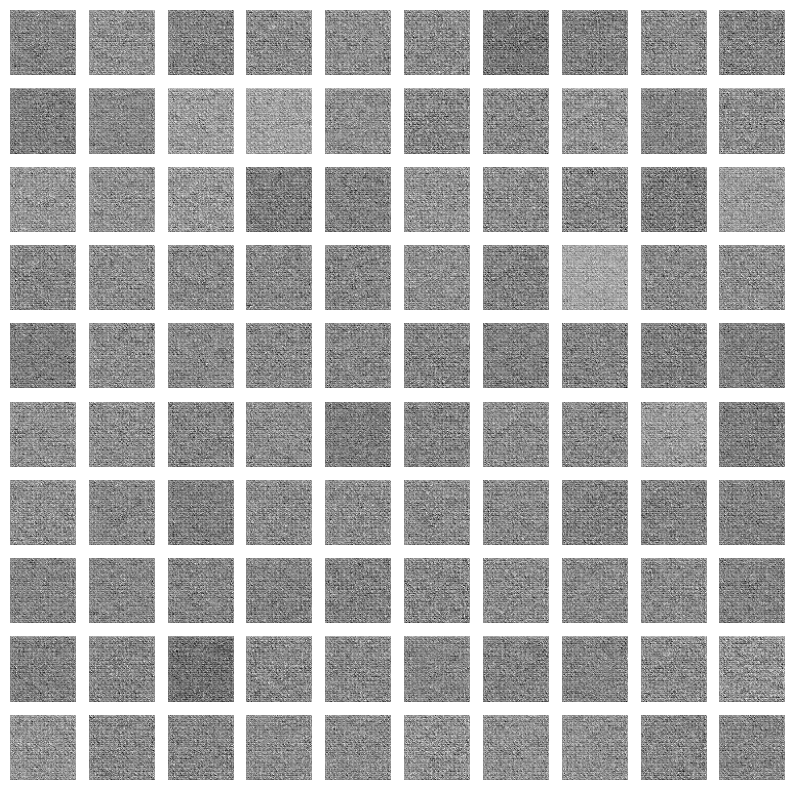

In [8]:
# Generate 100 random samples
z = np.random.normal(size=(100, latent_dim))
generated_imgs = vae.decode(z)

# Plot generated images
fig, axs = plt.subplots(10, 10, figsize=(10, 10))
for i in range(10):
    for j in range(10):
        axs[i,j].imshow(generated_imgs[i*10+j,:,:,0], cmap='gray')
        axs[i,j].axis('off')
plt.show()

In [9]:
# Generate 100 random samples from original dataset
sample_idxs = np.random.choice(imgs.shape[0], size=100, replace=False)
sample_imgs = imgs[sample_idxs]

# Plot original images
fig, axs = plt.subplots(10, 10, figsize=(10, 10))
for i in range(10):
    for j in range(10):
        axs[i,j].imshow(sample_imgs[i*10+j,:,:,0], cmap='gray')
        axs[i,j].axis('off')
plt.show()

NameError: ignored